In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo

Pulse energy before Simple Fiber : 2000.0 nJ
pulse energy in  775967.3959214971
copied as   775967.3959214971
Step: 0 Distance remaining: 1.0
Pulse energy after: 1986.5659472082089 nJ
Step: 1 Distance remaining: 0.98
Pulse energy after: 1986.5587721551533 nJ
Step: 2 Distance remaining: 0.96
Pulse energy after: 1986.5519503776316 nJ
Step: 3 Distance remaining: 0.94
Pulse energy after: 1986.5454812609667 nJ
Step: 4 Distance remaining: 0.92
Pulse energy after: 1986.5393640575649 nJ
Step: 5 Distance remaining: 0.9
Pulse energy after: 1986.5335978887877 nJ
Step: 6 Distance remaining: 0.88
Pulse energy after: 1986.5281817467446 nJ
Step: 7 Distance remaining: 0.86
Pulse energy after: 1986.5231144963952 nJ
Step: 8 Distance remaining: 0.84
Pulse energy after: 1986.5183948776603 nJ
Step: 9 Distance remaining: 0.82
Pulse energy after: 1986.5140215078766 nJ
Step: 10 Distance remaining: 0.8
Pulse energy after: 1986.5099928861487 nJ
Step: 11 Distance remaining: 0.78
Pulse energy after: 1986.50630739

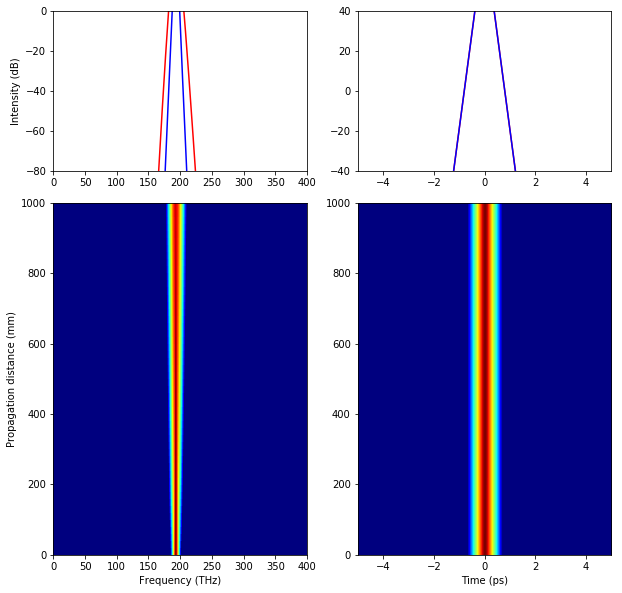

In [3]:
FWHM    = 0.16   # pulse duration (ps)
pulseWL = 1550   # pulse central wavelength (nm)
EPP     = 2e-6   # Energy per pulse (J)
GDD     = 0.0    # Group delay dispersion (ps^2)
TOD     = 0.0    # Third order dispersion (ps^3)

Window  = 10.0   # simulation window (ps)
Steps   = 50     # simulation steps
Points  = 2**13  # simulation points

Length  = 1000   # length in mm
Alpha   = 0.0    # attentuation coefficient (dB/cm)

# Xe gas, at 800nm, dispersive coefficients (betas), nonlinear refractive index (n2)
beta2 = 0.9113   # (fs^2/cm)
beta3 = 0.7836   # (fs^3/cm)

beta2 *= (1e-3)**2/1e-5      # (ps^2/km)
beta3 *= (1e-3)**3/1e-5      # (ps^3/km)
beta4 = 0                    # (ps^4/km)

n2 = 11.15e-19    # (cm^2/W)

# Assumed fiber radius
fiber_rad = 25e-6 # radius (m)

Gamma = ((2*np.pi)/(pulseWL*1e-9)) * ((n2*(1e-2)**2)/(np.pi*fiber_rad**2)) * (1/1e-3)# Gamma (1/(W km)

fibWL   = pulseWL # Center WL of fiber (nm)

Raman   = True    # Enable Raman effect?
Steep   = True    # Enable self steepening?

alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m


# set up plots for the results:
fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)


######## This is where the PyNLO magic happens! ############################

# create the pulse!
pulse = pynlo.light.DerivedPulses.SechPulse(1, FWHM/1.76, pulseWL, time_window_ps=Window,
                  GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=100, power_is_avg=False)
pulse.set_epp(EPP) # set the pulse energy

# create the fiber!
fiber1 = pynlo.media.fibers.fiber.FiberInstance()
fiber1.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=(beta2, beta3, beta4),
                              gamma_W_m=Gamma * 1e-3, gvd_units='ps^n/km', gain=-alpha)

# Propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True,
                 disable_Raman=np.logical_not(Raman),
                 disable_self_steepening=np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps)

########## That's it! Physic done. Just boring plots from here! ################


F = pulse.W_mks / (2 * np.pi) * 1e-12 # convert to THz

def dB(num):
    return 10 * np.log10(np.abs(num)**2)

zW = dB( np.transpose(AW)[:, (F > 0)] )
zT = dB( np.transpose(AT) )

y = y * 1e3 # convert distance to mm


ax0.plot(F[F > 0],  zW[-1], color='r')
ax1.plot(pulse.T_ps,zT[-1], color='r')

ax0.plot(F[F > 0],   zW[0], color='b')
ax1.plot(pulse.T_ps, zT[0], color='b')


extent = (np.min(F[F > 0]), np.max(F[F > 0]), 0, Length)
ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 60.0,
                 vmax=np.max(zW), aspect='auto', origin='lower', cmap='jet')

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y), Length)
ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
           vmax=np.max(zT), aspect='auto', origin='lower', cmap='jet')


ax0.set_ylabel('Intensity (dB)')

ax2.set_xlabel('Frequency (THz)')
ax3.set_xlabel('Time (ps)')

ax2.set_ylabel('Propagation distance (mm)')

ax2.set_xlim(0,400)

ax0.set_ylim(-80,0)
ax1.set_ylim(-40,40)

plt.show()

In [4]:
print(beta2, beta3, Gamma)

(0.09113, 7.83599999999999e-05, 0.00023019354838709638)
